# Import modules

In [33]:
import numpy as np
import matplotlib.pyplot as plt
import glob
import os
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
from matplotlib import colormaps
from datetime import timedelta
from scipy.signal import savgol_filter
from scipy.optimize import curve_fit
from scipy.stats import linregress

# Absorbance curves over time

## Initial plot

145


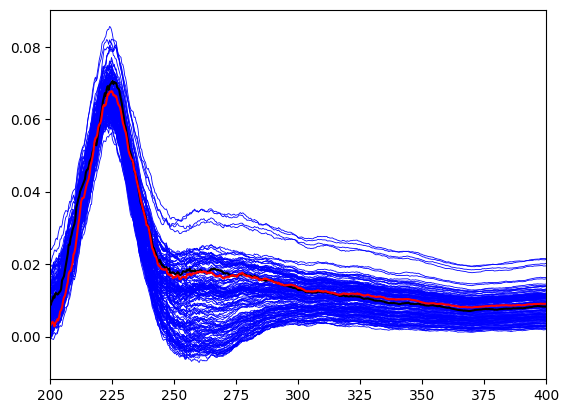

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import glob

exp_folder = './24hr_27052025'

skip = 40

for file in glob.glob(f'{exp_folder}/*.txt'):
    if 'Background' in file: x, I_background = np.loadtxt(file,skiprows=skip,usecols=(0,1),unpack=True)
    if 'Reference' in file: x, I_ref = np.loadtxt(file,skiprows=skip,usecols=(0,1),unpack=True)

count = 0

for file in glob.glob(f'{exp_folder}/*.txt'):
    if 'Reference' not in file and 'Background' not in file: 
        x, I = np.loadtxt(file,skiprows=skip,usecols=(0,1),unpack=True)
        abs = -np.log10((I - I_background)/(I_ref - I_background))
        plt.plot(x,abs,'b-',lw=0.6)
        count += 1

x, I = np.loadtxt(f'{exp_folder}/24HourExp_27052025_FLMS018081_10-08-22-355.txt',usecols=(0,1),skiprows=skip,unpack=True)
abs = -np.log10((I - I_background)/(I_ref - I_background))
plt.plot(x, abs, 'k-')

x, I = np.loadtxt(f'{exp_folder}/24HourExp_27052025_FLMS018081_10-48-22-285.txt',usecols=(0,1),skiprows=skip,unpack=True)
abs = -np.log10((I - I_background)/(I_ref - I_background))
plt.plot(x, abs, 'r-')

print(count)
    
plt.xlim(200.0,400.0)
plt.show()

## Processing and setup

In [7]:
skip = 40
exp_folder = './24hr_27052025'

# extracting timestamp
def extract_time_seconds(filename):
    time_str = filename.split('_')[-1].replace('.txt', '')
    h, m, s, ms = map(int, time_str.split('-'))
    return h * 3600 + m * 60 + s + ms / 1000.0

# sort by time
exp_files = [file for file in glob.glob(f'{exp_folder}/*.txt') if '24HourExp' in file]
exp_files.sort(key=lambda f: extract_time_seconds(os.path.basename(f)))
times = [extract_time_seconds(os.path.basename(f)) for f in exp_files]

# Colormap
norm = Normalize(vmin=min(times), vmax=max(times))
cmap = colormaps['inferno']

# background and reference
I_background = I_ref = None
for file in glob.glob(f'{exp_folder}/*.txt'):
    if 'Background' in file:
        x, I_background = np.loadtxt(file, skiprows=skip, usecols=(0, 1), unpack=True)
    elif 'Reference' in file:
        x, I_ref = np.loadtxt(file, skiprows=skip, usecols=(0, 1), unpack=True)

## Colour-coded 
Plotting all curves over time, colour coded to see time progression.

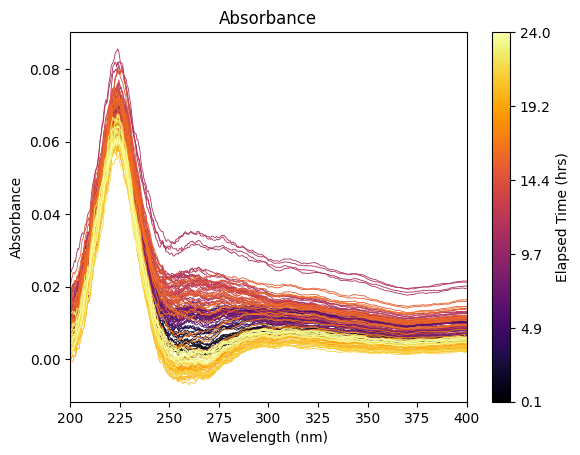

Total plotted: 145


In [9]:
fig, ax = plt.subplots()

# === Plot all absorbance traces with time-color
for i, (file, t) in enumerate(zip(exp_files, times)):
    x, I = np.loadtxt(file, skiprows=skip, usecols=(0, 1), unpack=True)
    abs = -np.log10((I - I_background) / (I_ref - I_background))
    ax.plot(x, abs, color=cmap(norm(t)), lw=0.6)
    
# === Plot background and reference
# ax.plot(x, -np.log10((I_background - I_background)/(I_ref - I_background)), color='blue', lw=1.5, label='Background')
# ax.plot(x, -np.log10((I_ref - I_background)/(I_ref - I_background)), color='black', lw=1.5, label='Reference')

# === Colorbar: Time progression
sm = ScalarMappable(norm=norm, cmap=cmap)
cbar = plt.colorbar(sm, ax=ax, label='Elapsed Time (hrs)')
tick_vals = np.linspace(min(times), max(times), 6)
tick_labels = [f"{t/3600:.1f}" for t in tick_vals]
cbar.set_ticks(tick_vals)
cbar.set_ticklabels(tick_labels)

# === Final touches
plt.xlim(200.0,400.0)
ax.set_xlabel('Wavelength (nm)')
ax.set_ylabel('Absorbance')
ax.set_title('Absorbance')
# ax.legend()
plt.show()

print(f"Total plotted: {len(exp_files)}")

## Normalised to 400 nm value (400 nm = 1)

Attempt 1: Setting the 400 nm value to 1 (NOT USING)

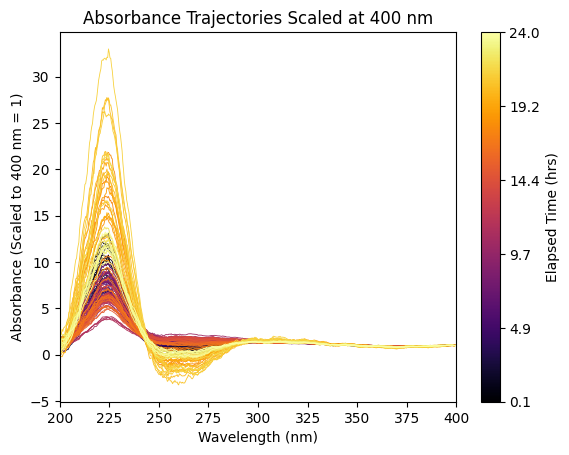

In [12]:
fig, ax = plt.subplots()

# Find index closest to 400 nm
idx_400 = np.argmin(np.abs(x - 400))

# Plot scaled absorbance traces
for file, t in zip(exp_files, times):
    x, I = np.loadtxt(file, skiprows=skip, usecols=(0, 1), unpack=True)
    abs = -np.log10((I - I_background) / (I_ref - I_background))
    scale_factor = abs[idx_400]
    if scale_factor == 0: continue  # avoid divide-by-zero
    abs_scaled = abs / scale_factor
    ax.plot(x, abs_scaled, color=cmap(norm(t)), lw=0.6)

# Plot reference and background (scaled)
# bg_abs = -np.log10((I_background - I_background) / (I_ref - I_background))
# ref_abs = -np.log10((I_ref - I_background) / (I_ref - I_background))
# ref_abs_scaled = ref_abs / ref_abs[idx_400]
# ax.plot(x, ref_abs_scaled, 'orange', lw=1.5, label='Reference')
# # background absorbance is undefined, plot as flat zero line
# ax.plot(x, np.zeros_like(x), 'green', lw=1.5, label='Background')

# Add colorbar
sm = ScalarMappable(norm=norm, cmap=cmap)
cbar = plt.colorbar(sm, ax=ax, label='Elapsed Time (hrs)')
tick_vals = np.linspace(min(times), max(times), 6)
tick_labels = [f"{t/3600:.1f}" for t in tick_vals]
cbar.set_ticks(tick_vals)
cbar.set_ticklabels(tick_labels)

# Plot settings
plt.xlim(200.0,400.0)
ax.set_xlabel('Wavelength (nm)')
ax.set_ylabel('Absorbance (Scaled to 400 nm = 1)')
ax.set_title('Absorbance Trajectories Scaled at 400 nm')
# ax.legend()
plt.show()

## Additive normalisation to 400 nm average

The average value for absorbance at 400 nm is used to shift all curves up or down to match it. 

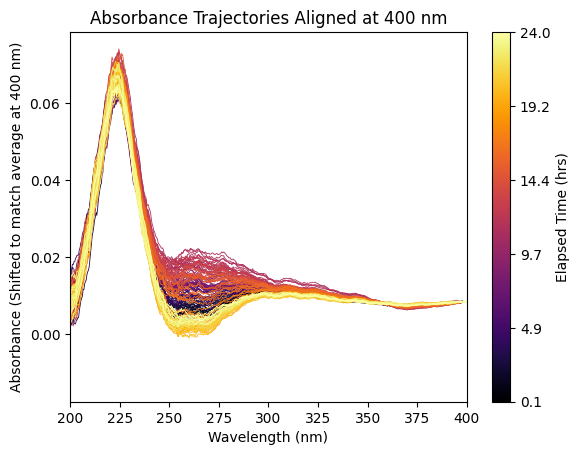

In [15]:
# Find index closest to 400 nm
idx_400 = np.argmin(np.abs(x - 400))

# Prepare absorbance traces and values at 400 nm
abs_traces = []
abs_at_400_list = []

for file in exp_files:
    x, I = np.loadtxt(file, skiprows=skip, usecols=(0, 1), unpack=True)
    abs_trace = -np.log10((I - I_background) / (I_ref - I_background))
    abs_traces.append(abs_trace)
    abs_at_400_list.append(abs_trace[idx_400])

# Compute average absorbance at 400 nm
avg_abs_400 = np.mean(abs_at_400_list)

# Plot settings
norm = Normalize(vmin=min(times), vmax=max(times))
cmap = colormaps['inferno']
fig, ax = plt.subplots()

# Plot adjusted traces
for abs_trace, t, abs_400 in zip(abs_traces, times, abs_at_400_list):
    shift = avg_abs_400 - abs_400
    abs_shifted = abs_trace + shift
    ax.plot(x, abs_shifted, color=cmap(norm(t)), lw=0.6)

# Add colorbar
sm = ScalarMappable(norm=norm, cmap=cmap)
cbar = plt.colorbar(sm, ax=ax, label='Elapsed Time (hrs)')
tick_vals = np.linspace(min(times), max(times), 6)
tick_labels = [f"{t/3600:.1f}" for t in tick_vals]
cbar.set_ticks(tick_vals)
cbar.set_ticklabels(tick_labels)

# Plot settings
plt.xlim(200.0, 400.0)
ax.set_xlabel('Wavelength (nm)')
ax.set_ylabel('Absorbance (Shifted to match average at 400 nm)')
ax.set_title('Absorbance Trajectories Aligned at 400 nm')
plt.show()


# Kinetics

In [42]:
# # === Extract time from filename ===
# def extract_time_seconds(filename):
#     time_str = filename.split('_')[-1].replace('.txt', '')
#     h, m, s, ms = map(int, time_str.split('-'))
#     return h * 3600 + m * 60 + s + ms / 1000.0

# # === Band averaging function ===
def band_averaged_absorbance(wavelengths, absorbance, center_nm=220, band_half_width=2):
    band_mask = (wavelengths >= center_nm - band_half_width) & (wavelengths <= center_nm + band_half_width)
    if not np.any(band_mask):
        raise ValueError(f"No wavelengths found in specified band around {center_nm} nm.")
    return np.mean(absorbance[band_mask])

## Initial plot

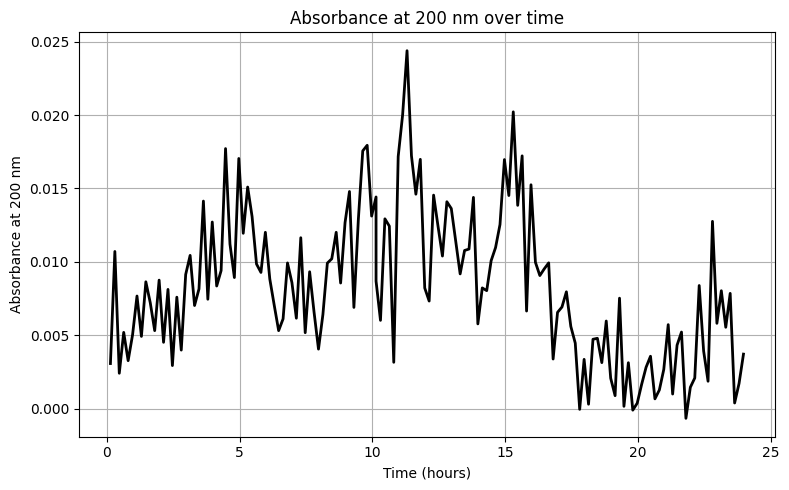

In [19]:
target_wavelength = 200

# find index closest to target
idx = np.argmin(np.abs(x - target_wavelength))

# find absorbance at specified wavelength
times = []
abs_values = []

for file in exp_files:
    x, I = np.loadtxt(file, skiprows=skip, usecols=(0, 1), unpack=True)
    abs_spectrum = -np.log10((I - I_background) / (I_ref - I_background))
    
    time_seconds = extract_time_seconds(os.path.basename(file))
    times.append(time_seconds / 3600)  # convert to hours
    abs_values.append(abs_spectrum[idx])

# Plot kinetics
plt.figure(figsize=(8, 5))
plt.plot(times, abs_values, '-', color='black', lw=2)
plt.xlabel('Time (hours)')
plt.ylabel(f'Absorbance at {target_wavelength} nm')
plt.title(f'Absorbance at {target_wavelength} nm over time')
plt.grid(True)
plt.tight_layout()
plt.show()


## Concentration plot using Beer Lambert law

Beer-Lambert law: <br>
A = elc <br>

with:<br>
e = 74 Lmol-1cm-1 (https://doi.org/10.1002/chem.202400728) <br>
l = 1 cm <br>
c = 1 molL-1 <br>

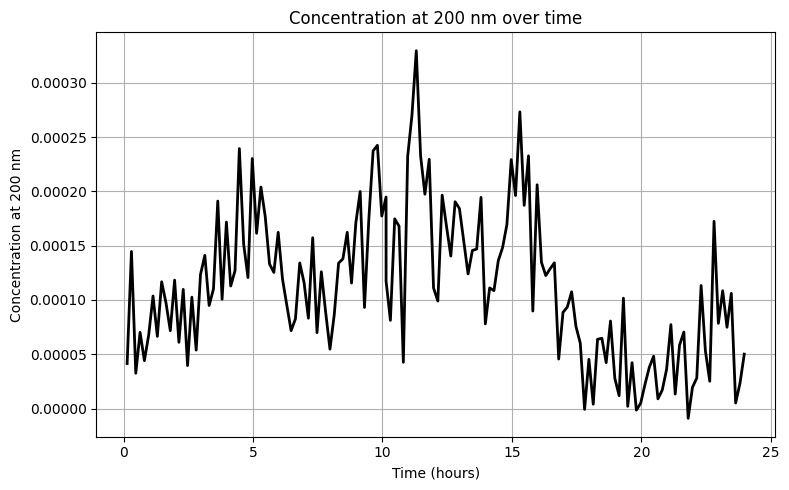

In [22]:
target_wavelength = 200

# find index closest to target
idx = np.argmin(np.abs(x - target_wavelength))

# find absorbance at specified wavelength
times = []
conc_values = []

for file in exp_files:
    x, I = np.loadtxt(file, skiprows=skip, usecols=(0, 1), unpack=True)
    abs_spectrum = -np.log10((I - I_background) / (I_ref - I_background))
    time_seconds = extract_time_seconds(os.path.basename(file))
    times.append(time_seconds / 3600)  # convert to hours
    conc = abs_spectrum[idx] / (74*1)  # Beer Lambert law to find concentration
    conc_values.append(conc)
    

# === Plot kinetics
plt.figure(figsize=(8, 5))
plt.plot(times, conc_values, '-', color='black', lw=2)
plt.xlabel('Time (hours)')
plt.ylabel(f'Concentration at {target_wavelength} nm')
plt.title(f'Concentration at {target_wavelength} nm over time')
plt.grid(True)
plt.tight_layout()
plt.show()

## Concentration plot with normalisation to 400 nm avg

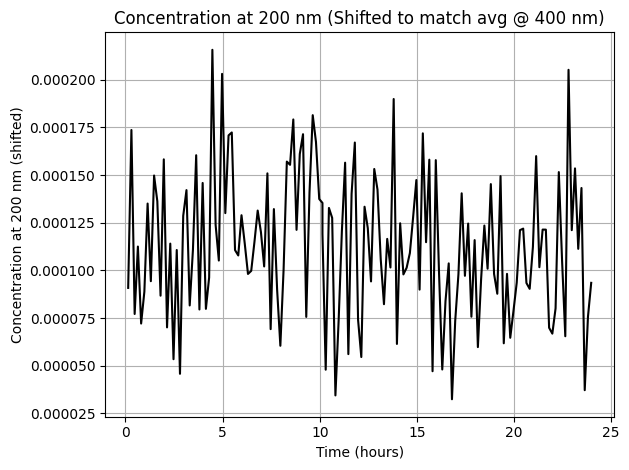

In [24]:
target_wavelength = 200  # nm

# Find indices for 400 nm and target wavelength (e.g. 220 nm)
idx_400 = np.argmin(np.abs(x - 400))
idx_target = np.argmin(np.abs(x - target_wavelength))

# Prepare absorbance traces and values at 400 nm
times = []
abs_traces = []
abs_at_400_list = []

for file in exp_files:
    x, I = np.loadtxt(file, skiprows=skip, usecols=(0, 1), unpack=True)
    abs_trace = -np.log10((I - I_background) / (I_ref - I_background))
    abs_traces.append(abs_trace)
    abs_at_400_list.append(abs_trace[idx_400])
    
    time_seconds = extract_time_seconds(os.path.basename(file))
    times.append(time_seconds / 3600)  # convert to hours

# Compute average absorbance at 400 nm
avg_abs_400 = np.mean(abs_at_400_list)

# Compute shifted absorbance at target wavelength (e.g. 200 nm)
conc_values = []
for abs_trace, abs_400 in zip(abs_traces, abs_at_400_list):
    shift = avg_abs_400 - abs_400
    abs_shifted = abs_trace + shift
    conc = abs_shifted[idx_target] / (74*1) # beer lambert law
    conc_values.append(conc)

# Plot kinetics
plt.figure()
plt.plot(times, conc_values, marker=None, color = 'black')
plt.xlabel('Time (hours)')
plt.ylabel(f'Concentration at {target_wavelength} nm (shifted)')
plt.title(f'Concentration at {target_wavelength} nm (Shifted to match avg @ 400 nm)')
plt.grid(True)
plt.tight_layout()
plt.show()

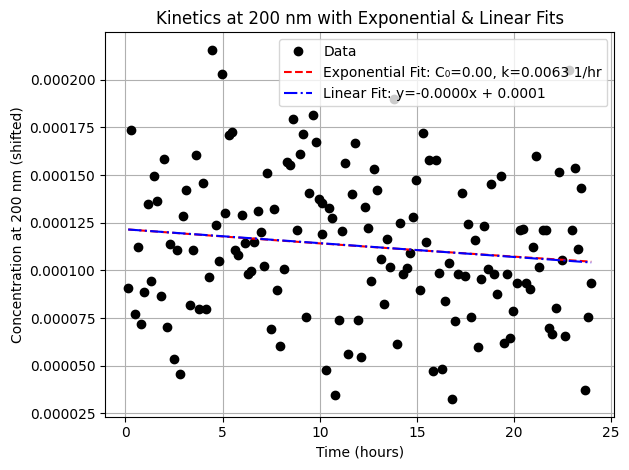

Exponential Fit: C₀ = 0.0001, k = 0.0063 1/hour
Linear Fit: slope = -0.0000 μM/hour, intercept = 0.0001


In [52]:
target_wavelength = 200  # nm

# Find indices for 400 nm and target wavelength (e.g. 220 nm)
idx_400 = np.argmin(np.abs(x - 400))
idx_target = np.argmin(np.abs(x - target_wavelength))

# Prepare absorbance traces and values at 400 nm
times = []
abs_traces = []
abs_at_400_list = []

for file in exp_files:
    x, I = np.loadtxt(file, skiprows=skip, usecols=(0, 1), unpack=True)
    abs_trace = -np.log10((I - I_background) / (I_ref - I_background))
    abs_traces.append(abs_trace)
    abs_at_400_list.append(abs_trace[idx_400])
    
    time_seconds = extract_time_seconds(os.path.basename(file))
    times.append(time_seconds / 3600)  # convert to hours

# Compute average absorbance at 400 nm
avg_abs_400 = np.mean(abs_at_400_list)

# Compute shifted absorbance at target wavelength (e.g. 200 nm) and then convert to concentration
conc_values = []
for abs_trace, abs_400 in zip(abs_traces, abs_at_400_list):
    shift = avg_abs_400 - abs_400
    abs_shifted = abs_trace + shift
    conc = abs_shifted[idx_target] / (74*1)  # Beer-Lambert Law
    conc_values.append(conc)

# --- Fitting Section ---

# Convert lists to arrays for fitting
times = np.array(times)
conc_values = np.array(conc_values)

# 1. Exponential decay fit
def first_order_decay(t, C0, k):
    return C0 * np.exp(-k * t)

initial_guess = [conc_values[0], 0.01]
popt_exp, _ = curve_fit(first_order_decay, times, conc_values, p0=initial_guess)
C0_fit, k_fit = popt_exp

t_fit = np.linspace(min(times), max(times), 200)
conc_exp_fit = first_order_decay(t_fit, *popt_exp)

# 2. Linear fit
slope, intercept, r_value, p_value, std_err = linregress(times, conc_values)
conc_lin_fit = slope * t_fit + intercept

# --- Plotting ---
plt.figure()
plt.plot(times, conc_values, 'ko', label='Data')
plt.plot(t_fit, conc_exp_fit, 'r--', label=f'Exponential Fit: C₀={C0_fit:.2f}, k={k_fit:.4f} 1/hr')
plt.plot(t_fit, conc_lin_fit, 'b-.', label=f'Linear Fit: y={slope:.4f}x + {intercept:.4f}')
plt.xlabel('Time (hours)')
plt.ylabel(f'Concentration at {target_wavelength} nm (shifted)')
plt.title(f'Kinetics at {target_wavelength} nm with Exponential & Linear Fits')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# --- Print extracted parameters ---
print(f"Exponential Fit: C₀ = {C0_fit:.4f}, k = {k_fit:.4f} 1/hour")
print(f"Linear Fit: slope = {slope:.4f} μM/hour, intercept = {intercept:.4f}")


## Band averaging for a specified range

In [44]:
# === PARAMETERS ===
# exp_folder = './24hr_27052025'
# skip = 40  # header rows to skip in files
center_wavelength = 200  # nm
band_half_width = 20      # +/- nm for averaging
normalisation_wavelength = 400  # nm

# # === Load experimental files ===
# exp_files = [f for f in glob.glob(f'{exp_folder}/*.txt') if '24HourExp' in f]
# exp_files.sort(key=lambda f: extract_time_seconds(os.path.basename(f)))
# times_sec = [extract_time_seconds(os.path.basename(f)) for f in exp_files]

# # === Load background and reference ===
# I_background = I_ref = None
# for file in glob.glob(f'{exp_folder}/*.txt'):
#     if 'Background' in file:
#         x, I_background = np.loadtxt(file, skiprows=skip, usecols=(0, 1), unpack=True)
#     elif 'Reference' in file:
#         _, I_ref = np.loadtxt(file, skiprows=skip, usecols=(0, 1), unpack=True)

# if I_background is None or I_ref is None:
#     raise RuntimeError("Reference or background file not found.")

# === Find index of normalisation wavelength (e.g., 400 nm) ===
idx_norm = np.argmin(np.abs(x - normalisation_wavelength))

# === Pre-calculate average absorbance at normalisation wavelength ===
abs_at_400_list = []
for file in exp_files:
    _, I = np.loadtxt(file, skiprows=skip, usecols=(0, 1), unpack=True)
    abs_trace = -np.log10((I - I_background) / (I_ref - I_background))
    abs_at_400_list.append(abs_trace[idx_norm])
avg_abs_at_400 = np.mean(abs_at_400_list)

# === Extract absorbance at target wavelength band and shift ===
abs_values = []
for file in exp_files:
    _, I = np.loadtxt(file, skiprows=skip, usecols=(0, 1), unpack=True)
    abs_trace = -np.log10((I - I_background) / (I_ref - I_background))
    
    shift_val = abs_trace[idx_norm] - avg_abs_at_400
    abs_shifted = abs_trace - shift_val

    avg_abs = band_averaged_absorbance(x, abs_shifted, center_nm=center_wavelength, band_half_width=band_half_width)
    abs_values.append(avg_abs)

# === Convert times to hours for plotting ===
times_hrs = np.array(times_sec) / 3600

# === Plotting ===
plt.figure(figsize=(8, 5))
plt.plot(times_hrs, abs_values, color='black', lw=1)
plt.xlabel("Time (hours)")
plt.ylabel(f"Absorbance @ {center_wavelength} nm ±{band_half_width} nm (shifted)")
plt.title(f"Kinetics at {center_wavelength} nm (Shifted to match avg @ {normalisation_wavelength} nm)")
plt.grid(True)
plt.tight_layout()
plt.show()

NameError: name 'times_sec' is not defined